<a href="https://colab.research.google.com/github/Lilchoto3/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [86]:
# 1: Write a program using the Bayesian formula
def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):
  # cast all inputs as floats just in case
  prob_drunk_prior = float(prob_drunk_prior)
  false_positive_rate = float(false_positive_rate)

  # This will be needed later
  inverse_drunk_prior = 1 - prob_drunk_prior

  # set up the bayes equation

  # Numerator
  prob_numer = 1 * prob_drunk_prior

  # Denominator
  prob_denom = 1 * (prob_drunk_prior) + (false_positive_rate) * (inverse_drunk_prior)

  probability = prob_numer / prob_denom
  return probability

# Test the function

# I'm going to use a while loop because I don't want to have to re-write the function for every time it doesn't work
prob_actually_drunk = (1/1000)
prob_previous = 0 # anti-infinite loop variable
i = 0 # enumerator to keep track
while prob_actually_drunk <= 0.95:
  prob_previous = prob_actually_drunk
  prob_actually_drunk = prob_drunk_given_positive(prob_actually_drunk, .08)
  i+=1
  print(f"Test {i}: {prob_actually_drunk}% positive")
  if prob_previous == prob_actually_drunk:
    print(f"Infinite loop reached at test {i}, value: {prob_actually_drunk}")
    break

Test 1: 0.012357884330202669% positive
Test 2: 0.13525210993291495% positive
Test 3: 0.6615996951348605% positive
Test 4: 0.9606895076105054% positive


In [87]:
# 2: Explore scipy.stats.bayes_mvs
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Generate 50 coinflips
coinflips = np.random.binomial(n=1, p=.5, size=20)

results = []
results_y = []

bayes_confs, _, _ = stats.bayes_mvs(coinflips, alpha=.95)

bayes_confs = pd.DataFrame(bayes_confs).T

bayes_confs.columns = ['statistic', 'minmax']

bayes_confs

,statistic,minmax
0,0.7,"(0.4799572487244166, 0.9200427512755833)"


In [88]:
def freq_conf(sample, confidence=.95):
  sample = np.array(sample)
  mean = np.mean(sample)
  n = len(sample)
  stddev = np.std(sample, ddof=1)/np.sqrt(n)
  var = stddev**2
  t = stats.t.ppf((1+confidence)/2.0, n-1)
  moe = t * stddev
  low = mean - moe
  high = mean + moe
  returnframe = pd.DataFrame({'statistic':[mean],'minmax':[(low, high)]})
  return returnframe

freq_confs = freq_conf(coinflips)

freq_confs

,statistic,minmax
0,0.7,"(0.4799572487244166, 0.9200427512755833)"


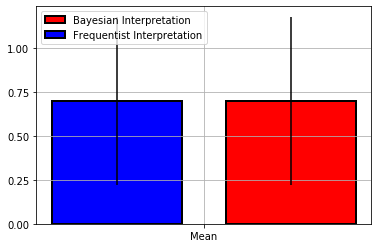

In [89]:
fig, ax = plt.subplots()

ax.bar([0.1], bayes_confs.statistic, yerr=bayes_confs.minmax,color='red',edgecolor='black',linewidth=2, width=0.15, label='Bayesian Interpretation')
ax.bar([-0.1], freq_confs.statistic, yerr=freq_confs.minmax, color='blue',edgecolor='black',linewidth=2, width=0.15, label='Frequentist Interpretation')

ax.set_xticks([0])
ax.set_xticklabels(['Mean'])

ax.set_yticks([0,0.25,0.5,0.75,1])

ax.grid(b=True, which='both')

ax.legend(loc='upper left')

plt.show()

# As much as I'm glad I was able to get this to work, I'm not satisfied
# From what I see on the graph vs. what I see in the numbers
# it seems like both the bayesian and frequentist confidence interval notations
# end up with the same mean and error values.
# I think this has to do with how Bayesian statistics works
#
# Maybe it's because I'm using generated coinflip data as my sample data that's
# causing them to come to the same conclusion, since the data's so simple, but still
#
# In the lecture the numbers were different, but now I see that was because
# the confidence intervals were too.
#
# Also, while I was able to get the bar graph with the error lines working,
# I think they're being graphed wrong; the max error should not be going over 1

**3: Difference between Bayesian and Frequentist statistics**

From what I understand, the main difference is in how each system is used. Frequentist statistics is for samples of populations, to get a one-and-done idea of how the population might look, within a certain preset value of confidence. Bayesian statistics on the other hand is all about iterating what you know about the data over and over, building the confidence interval by learning more and more about the data.

I think, with the way I did it here, I used the Bayesian approach in a one-and-done way like how the Frequentist approach works, and as such I got the same answers in the end.

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!